## Supplement 4: Classification

In [29]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
import warnings
warnings.filterwarnings('ignore', message='.*overflow.*')

### 4.3 Programming Task: Song popularity prediction using Logistic regression
The datasets __train-songs.csv__ and __test-songs.csv__ contain audio properties of various tracks collected from the music streaming site Spotify.


The goal of the task is to train a logistic regression classifier that predicts if
a given track is popular or not.
The dataset consists of 9 columns.
The first 8 columns contain various audio properties
which are provided as input features to the model.
The last column contains the class labels given by 0(not popular) and 1(popular).

i\. Implement the loss function and its gradient for the logistic regression model.
 

In [30]:
train_set = pd.read_csv('train-songs.csv').to_numpy()
test_set = pd.read_csv('test-songs.csv').to_numpy()
n_samples_train = train_set.shape[0]
n_samples_test = test_set.shape[0]
train_X = train_set[:,:-1]
train_y = train_set[:,-1]
test_X = test_set[:,:-1]
test_y = test_set[:,-1]
# normalize data
mean = np.mean(train_X, axis=0)
std = np.std(train_X, axis=0)
train_X = (train_X - np.tile(mean, (n_samples_train, 1))) / np.tile(std, (n_samples_train, 1))
test_X = (test_X - np.tile(mean, (n_samples_test, 1))) / np.tile(std, (n_samples_test, 1))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def loss_log_reg(w, train_X, train_y):
    n_samples = train_X.shape[0]
    x = np.concatenate((np.ones((n_samples, 1)), train_X), axis=1)
    eps = 1e-13
    h_w = sigmoid(np.sum(np.tile(w, (n_samples, 1)) * x, axis=1))
    h_w[h_w < eps] = eps
    h_w[h_w > (1-eps)] = 1-eps
    loss = train_y * np.log(h_w) + (1-train_y) * np.log(1-h_w)
    loss = -1/n_samples * np.sum(loss)
    return loss

def grad_log_reg(w, train_X, train_y):
    n_samples = train_X.shape[0]
    n_w = train_X.shape[1] + 1
    x = np.concatenate((np.ones((n_samples, 1)), train_X), axis=1)
    h_w = sigmoid(np.sum(np.tile(w, (n_samples, 1)) * x, axis=1))
    grad = np.tile((h_w - train_y).reshape((n_samples, 1)), (1, n_w)) * x
    grad = 1/n_samples * np.sum(grad, axis=0)
    return grad

   ii\. Using the gradient descent algorithm, train the logistic regression model.
You may reuse/modify the gradient descent algorithm from the previous supplement.




In [31]:
def grad_descent(init, train_X, train_y, alpha, tol=1e-3, max_i=1000, print_loss=False):
    w = np.array(init)
    # distance between two samples
    grad = grad_log_reg(w, train_X, train_y)
    i = 0
    if print_loss:
        loss = loss_log_reg(w, train_X, train_y)
        grad_norm = np.linalg.norm(grad)
        print(f'i = {i:3d}: L = {loss}; G_norm = {grad_norm}')
    while np.linalg.norm(grad) > tol: # finish in case of very flat local area
        w = w - alpha * grad
        grad = grad_log_reg(w, train_X, train_y)
        i += 1
        if print_loss and not (i % 100):
            loss = loss_log_reg(w, train_X, train_y)
            grad_norm = np.linalg.norm(grad)
            print(f'i = {i:3d}: L = {loss}; G_norm = {grad_norm}')
        if i == max_i: break
    return w, i

w, i = grad_descent(np.full(9, 0), train_X, train_y, max_i=2e3, alpha=1e-1, tol=1e-3, print_loss=True)
print(f'GD finished after {i} iterations')
print('Final w:', w)

i =   0: L = 0.6931471805599453; G_norm = 0.4271675639878617
i = 100: L = 0.4378183795649243; G_norm = 0.052456636171881905
i = 200: L = 0.42432874746810606; G_norm = 0.024833106397781492
i = 300: L = 0.42060398660193987; G_norm = 0.01452602269721274
i = 400: L = 0.4192361832867092; G_norm = 0.009133447983599188
i = 500: L = 0.4186782869688179; G_norm = 0.00593212574629737
i = 600: L = 0.41843904907954893; G_norm = 0.0039201140968283185
i = 700: L = 0.4183335628954958; G_norm = 0.002617239455782581
i = 800: L = 0.4182862572553685; G_norm = 0.0017587217584365744
i = 900: L = 0.41826481213446026; G_norm = 0.0011868092915719394
GD finished after 944 iterations
Final w: [-3.21795455e-01  3.59233494e-01  1.21105969e-02  1.80287145e+00
 -8.52836303e-01 -6.04396919e-02  1.53934694e-03 -2.28942161e-01
  7.59339020e-02]


iii\. Using model predictions on __test-songs.csv__, build the confusion
matrix and subsequently calculate the precision, recall, and F1-score for a threshold of 0.4.


Precision: 0.7485331098072087
Recall: 0.893
F1-score: 0.8144094847241222


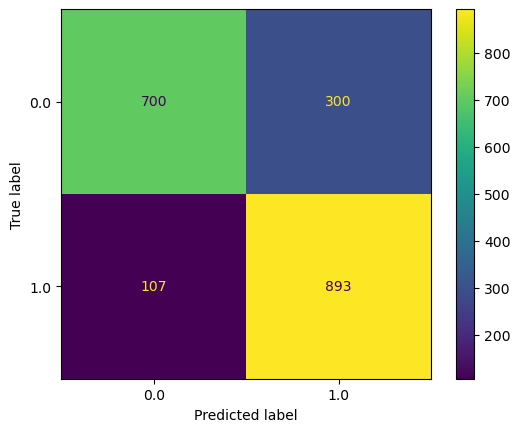

In [32]:
def calculate_prediction(w, test_X):
    n_test_samples = test_X.shape[0]
    x = np.concatenate((np.ones((n_test_samples, 1)), test_X), axis=1)
    z = np.sum(np.tile(w, (n_test_samples, 1)) * x, axis=1)
    pred_y = sigmoid(z)
    return pred_y

def get_precision(y_true, y_pred_bin):
    y_pred_pos = y_pred_bin[y_true==1]
    return np.sum(y_pred_pos) / np.sum(y_pred_bin)

def get_recall(y_true, y_pred_bin):
    y_pred_pos = y_pred_bin[y_true==1]
    return np.sum(y_pred_pos) / np.sum(y_true)

def get_f1_score(y_true, y_pred_bin):
    precision = get_precision(y_true, y_pred_bin)
    recall = get_recall(y_true, y_pred_bin)
    return 2 * precision * recall / (precision + recall)

pred_y = calculate_prediction(w, test_X)
pred_y_bin = np.zeros(pred_y.shape)
pred_y_bin[pred_y > 0.4] = 1
pred_y_bin[pred_y <= 0.4] = 0
ConfusionMatrixDisplay.from_predictions(test_y, pred_y_bin)
precision = get_precision(test_y, pred_y_bin)
recall = get_recall(test_y, pred_y_bin)
f_1 = get_f1_score(test_y, pred_y_bin)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f_1)

iv\. Plot the ROC curve for the model and calculate the AUC metric of your model.


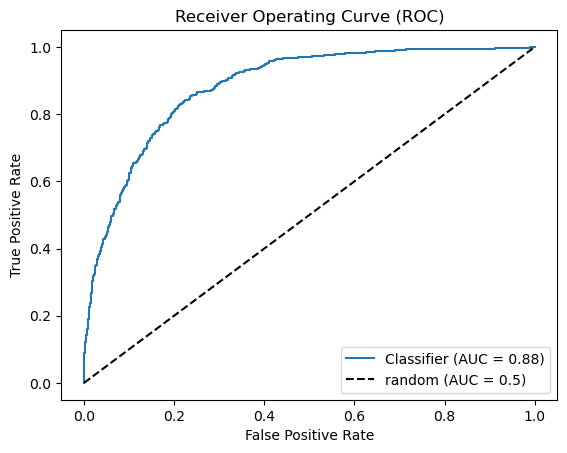

In [33]:
RocCurveDisplay.from_predictions(test_y, pred_y)
plt.plot([0,1], [0,1], 'k--', label='random (AUC = 0.5)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Curve (ROC)")
plt.legend(loc='lower right')
plt.show()

v\. Consider the simpler models given below.The input $\mathbf{x}$ in these models takes only 4 input features from the given dataset.

- Model A $~~~~~~~~~~~$   $\mathbf{x}$ = $[$ danceability, key, valence, tempo $]^\top$
- Model B $~~~~~~~~~~~$  $\mathbf{x}$ = $[$ danceability, loudness, acousticness, instrumentalness $]^\top$
- Model C $~~~~~~~~~~~$ $\mathbf{x}$ = $[$ key, liveness, valence, tempo $]^\top$

Train these models using your logistic regression implementation and determine the best performing model using the AUC metric.

GD finished after 400 iterations
AUC_A: 0.659474
GD finished after 946 iterations
AUC_B: 0.8795580000000002
GD finished after 166 iterations
AUC_C: 0.561585


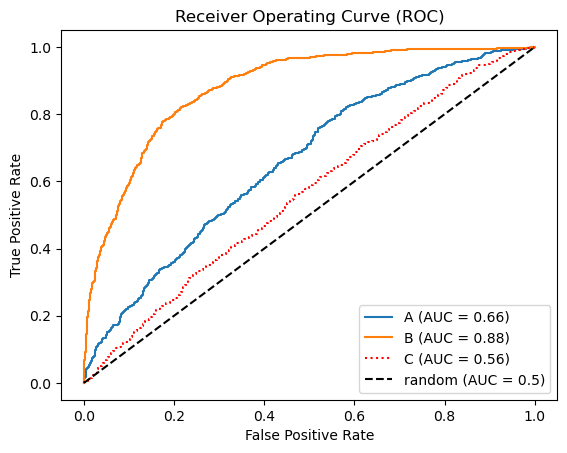

In [34]:
# 0: danceability, 1: key, 2: loudness, 3: acousticness, 4: instrumentalness, 5: liveness, 6: valence, 7: tempo
# A
mask = [0, 1, 6, 7]
w, i = grad_descent(np.zeros(5), train_X[:,mask], train_y, max_i=2e3, alpha=1e-1, tol=1e-3)
print(f'GD finished after {i} iterations')
pred_y = calculate_prediction(w, test_X[:,mask])
roc_display_a = RocCurveDisplay.from_predictions(test_y, pred_y, name='A')
auc = roc_auc_score(test_y, pred_y)
print('AUC_A:', auc)
# B
mask = [0, 2, 3, 4]
w, i = grad_descent(np.zeros(5), train_X[:,mask], train_y, max_i=2e3, alpha=1e-1, tol=1e-3)
print(f'GD finished after {i} iterations')
pred_y = calculate_prediction(w, test_X[:,mask])
RocCurveDisplay.from_predictions(test_y, pred_y, ax=roc_display_a.ax_, name='B')
auc = roc_auc_score(test_y, pred_y)
print('AUC_B:', auc)
# C
mask = [1, 5, 6, 7]
w, i = grad_descent(np.zeros(5), train_X[:,mask], train_y, max_i=2e3, alpha=1e-1, tol=1e-3)
print(f'GD finished after {i} iterations')
pred_y = calculate_prediction(w, test_X[:,mask])
RocCurveDisplay.from_predictions(test_y, pred_y, ax=roc_display_a.ax_, name='C', linestyle=':', color='r')
auc = roc_auc_score(test_y, pred_y)
print('AUC_C:', auc)

plt.plot([0,1], [0,1], 'k--', label='random (AUC = 0.5)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Curve (ROC)")
plt.legend(loc='lower right')
plt.show()